# 神經網路實做

## 拿取加權指數資料

In [1]:
from finlab.data import Data

data = Data()
twii = data.get("發行量加權股價指數")

twii = twii['台股指數'].resample("15T").first().dropna()
twii.head()

date
2006-01-02 09:00:00    6548.34
2006-01-02 09:15:00    6478.09
2006-01-02 09:30:00    6474.88
2006-01-02 09:45:00    6471.12
2006-01-02 10:00:00    6480.50
Name: 台股指數, dtype: float64

## 製作features

In [2]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

    'return': twii.shift(-10) / twii,
})

feature_names = list(dataset.columns[:-1])

## 簡單處理一下

In [3]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)


before dropping NaN (80085, 43)
after dropping NaN (78157, 43)


In [4]:
import lightgbm as lgb
dataset_train = dataset[:'2015']

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 神經網路Preprocessing

In [5]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,RSIb,RSIb2,RSIb3,RSIb4,RSIb5,RSIb6,MOMb,KDb,KDb2,KDb3,...,b7,LINEARREG_SLOPE0,LINEARREG_SLOPE1,ADXR0,ADXR1,ADXR2,ADXR3,ADXR4,ADXR5,return
count,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,...,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,7.815700e+04,78157.000000
mean,1.934854e-15,-7.792798e-16,-3.827539e-15,-1.559037e-15,-5.201461e-15,-4.647749e-15,-3.347917e-16,1.073119e-17,-5.162554e-18,1.006320e-17,...,-2.725171e-15,-4.176707e-17,-4.111932e-17,9.324953e-16,-5.332571e-16,3.888487e-16,1.059130e-15,8.048474e-16,-5.497477e-16,1.000142
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.008244
min,-4.353235e+00,-4.498580e+00,-4.776231e+00,-4.760100e+00,-4.725882e+00,-4.655893e+00,-8.778321e+00,-2.593938e+00,-2.687705e+00,-2.646516e+00,...,-5.438108e+00,-9.258234e+00,-7.019435e+00,-2.076440e+00,-1.987535e+00,-1.698055e+00,-1.618776e+00,-1.763081e+00,-1.812671e+00,0.924507
25%,-6.827351e-01,-6.833477e-01,-6.680423e-01,-6.626360e-01,-6.560367e-01,-6.447950e-01,-4.630984e-01,-6.373052e-01,-6.419670e-01,-6.293523e-01,...,-5.336383e-01,-4.655022e-01,-4.712130e-01,-7.375342e-01,-6.979047e-01,-7.558942e-01,-7.076717e-01,-6.908158e-01,-7.266391e-01,0.996995
50%,9.119428e-02,1.131484e-01,1.158928e-01,1.229380e-01,1.284703e-01,1.345553e-01,8.290795e-02,-1.296513e-02,-3.194222e-02,-1.002124e-02,...,1.114561e-01,7.360363e-02,7.686490e-02,-1.542221e-01,-2.321241e-01,-2.756153e-01,-2.580724e-01,-2.331419e-01,-2.020684e-01,1.000285
75%,7.204536e-01,7.108853e-01,6.879982e-01,6.918861e-01,6.907457e-01,6.894526e-01,5.608996e-01,6.535609e-01,6.688928e-01,5.999781e-01,...,5.728762e-01,5.571236e-01,5.648297e-01,5.761189e-01,4.623303e-01,5.106372e-01,5.109298e-01,5.357694e-01,6.016581e-01,1.003715
max,3.218640e+00,2.793078e+00,3.011542e+00,3.092432e+00,3.112729e+00,3.127416e+00,5.236603e+00,2.735113e+00,2.593645e+00,2.537070e+00,...,4.809755e+00,4.660209e+00,4.652537e+00,4.728208e+00,4.043747e+00,3.770672e+00,3.523574e+00,3.648669e+00,3.505566e+00,1.087726


In [6]:
import tqdm

n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
#dataset_scaled.head()

In [7]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [8]:
indexes = np.array(indexes)

## 神經網路 Model

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation="relu", input_shape=(len(feature_names),)))
model.add(layers.LSTM(100, return_sequences=True, input_shape=X[0].shape))
model.add(layers.LSTM(100))
model.add(layers.Dense(8))
model.add(layers.Dense(1,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(0.0006)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\framework

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            57200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 138,417
Trainable params: 138,417
Non-trainable params: 0
_________________________________________________________________


## 神經網路訓練

In [10]:
# dataset_scaled_train = dataset_scaled[:'2015']

import datetime
X_train = X[indexes < datetime.datetime(2016, 1, 1)]
y_train = y[indexes < datetime.datetime(2016, 1, 1)]

checkpoint_filepath = './checkpoint_u22'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    X_train,
    y_train > 1,
    batch_size=5000,
    epochs=300,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback])

Train on 36175 samples, validate on 9044 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
36175/36175 [==============================] - ETA: 5s - loss: 4.8606 - acc: 0.470 - ETA: 2s - loss: 4.3844 - acc: 0.472 - ETA: 1s - loss: 3.9903 - acc: 0.476 - ETA: 1s - loss: 3.7017 - acc: 0.478 - ETA: 0s - loss: 3.4828 - acc: 0.479 - ETA: 0s - loss: 3.3145 - acc: 0.479 - ETA: 0s - loss: 3.1697 - acc: 0.479 - 3s 80us/sample - loss: 3.1358 - acc: 0.4798 - val_loss: 2.1065 - val_acc: 0.5036
Epoch 2/300
36175/36175 [==============================] - ETA: 1s - loss: 2.0650 - acc: 0.494 - ETA: 0s - loss: 2.0810 - acc: 0.484 - ETA: 0s - loss: 2.0648 - acc: 0.481 - ETA: 0s - loss: 2.0450 - acc: 0.481 - ETA: 0s - loss: 2.0220 - acc: 0.482 - ETA: 0s - loss: 2.0096 - acc: 0.480 - ETA: 0s - loss: 1.9939 - acc: 0.480 - 2s 52us/sample - loss: 1.9908 - acc: 0.4798 - val_loss: 1.8271 - val_acc: 0.5036
Epoch 3/300
36175/36175 [====================

In [11]:
model.load_weights(checkpoint_filepath)

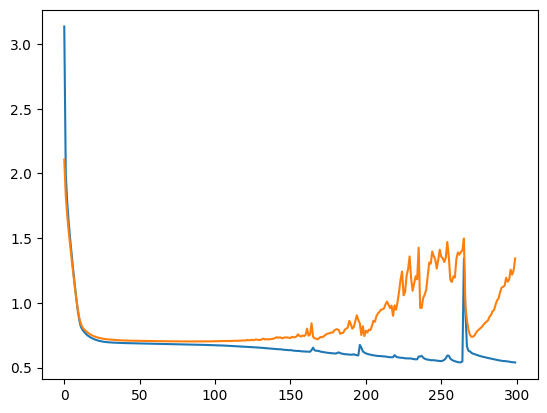

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 回測

<AxesSubplot:>

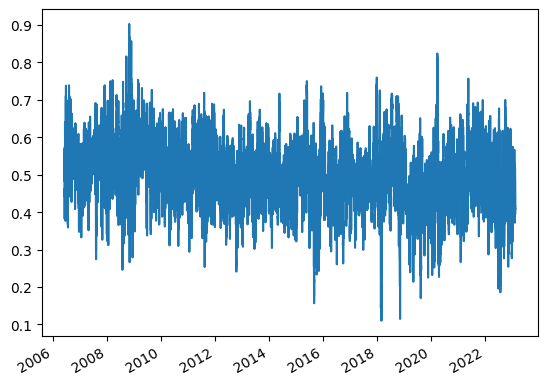

In [13]:
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()


<AxesSubplot:xlabel='date'>

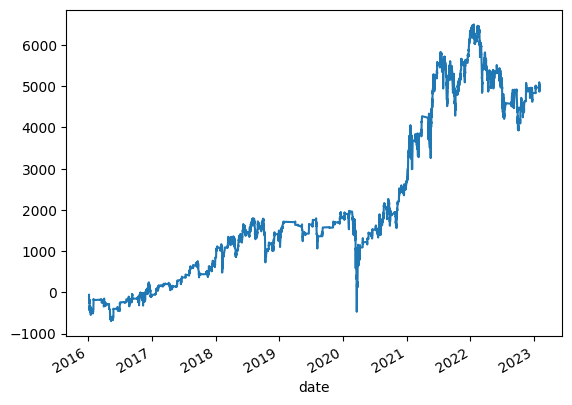

In [14]:
eq = twii[indexes]
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(10).sum() > 0
signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2016':]).cumsum()
eq.plot()

In [15]:
(signal.astype(int).diff().abs().fillna(0) * 3)['2016':].sum()

1485.0